<a href="https://colab.research.google.com/github/amirkasaei/Modified-Human-Sperm-Morphology-Analysis/blob/main/MAML_Modified_Human_Sperm_Morphology_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

## **Others**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.model_selection import KFold

import copy
import imageio
import PIL.Image as Image

import os
import sys
import time
import random
from tqdm import trange

from google.colab import drive
from numba import cuda

In [2]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/mhsma-dataset sperm images/mhsma/"

Mounted at /content/drive


## **Torch**

In [3]:
!pip install -q torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.4 MB/s eta 0:00:00


In [4]:
pip install -q --upgrade torch

In [5]:
pip install -q --upgrade torch torchvision

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torcheval
from torcheval.metrics.functional import binary_accuracy
from torchvision import transforms
import torchvision.transforms as T
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Resize

# PyTorch TensorBoard support
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

## **learn2learn**

In [7]:
!pip install -q git+https://github.com/locuslab/qpth

  Preparing metadata (setup.py) ... done


In [8]:
!pip install -q learn2learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 93.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [9]:
import learn2learn as l2l
from learn2learn.data.transforms import (NWays, KShots, LoadData, RemapLabels, ConsecutiveLabels)

# **Preprocessing**

## **Load Data**

In [10]:
!git clone https://github.com/amirkasaei/Modified-Human-Sperm-Morphology-Analysis/
path="/content/Modified-Human-Sperm-Morphology-Analysis/mhsma-dataset/mhsma/"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cloning into 'Modified-Human-Sperm-Morphology-Analysis'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 72 (delta 25), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (72/72), 13.88 MiB | 3.92 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [11]:
size = '64'
x_train = np.load(path + 'x_' + size + '_train.npy').astype('float32')
y_acrosome_train = np.load(path + 'y_acrosome_train.npy').astype('float32')
y_head_train = np.load(path + 'y_head_train.npy').astype('float32')
y_tail_train = np.load(path + 'y_tail_train.npy').astype('float32')
y_vacuole_train = np.load(path + 'y_vacuole_train.npy').astype('float32')

x_valid = np.load(path+'x_' + size + '_valid.npy').astype('float32')
y_acrosome_valid = np.load(path + 'y_acrosome_valid.npy').astype('float32')
y_head_valid = np.load(path + 'y_head_valid.npy').astype('float32')
y_tail_valid = np.load(path + 'y_tail_valid.npy').astype('float32')
y_vacuole_valid = np.load(path + 'y_vacuole_valid.npy').astype('float32')

x_test = np.load(path+'x_' + size + '_test.npy').astype('float32')
y_acrosome_test = np.load(path + 'y_acrosome_test.npy').astype('float32')
y_head_test = np.load(path + 'y_head_test.npy').astype('float32')
y_tail_test = np.load(path + 'y_tail_test.npy').astype('float32')
y_vacuole_test = np.load(path + 'y_vacuole_test.npy').astype('float32')

print('x_train shape:', x_train.shape, '----- y_acrosome_train shape:', y_acrosome_train.shape)
print('x_valid shape:', x_valid.shape, '----- y_acrosome_valid shape:', y_acrosome_valid.shape)
print('x_test shape:', x_test.shape, '----- y_acrosome_test shape:', y_acrosome_test.shape)

x_train shape: (1000, 64, 64) ----- y_acrosome_train shape: (1000,)
x_valid shape: (240, 64, 64) ----- y_acrosome_valid shape: (240,)
x_test shape: (300, 64, 64) ----- y_acrosome_test shape: (300,)


In [12]:
np.count_nonzero(y_head_train == 0)/y_head_train.shape[0]

0.727

In [13]:
np.count_nonzero(y_head_test == 0)/y_head_test.shape[0]

0.73

## **Reshape Data**

In [14]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
# y_acrosome_train = y_acrosome_train.reshape((-1,1))
# y_head_train = y_head_train.reshape((-1,1))
# y_tail_train = y_tail_train.reshape((-1,1))
# y_vacuole_train = y_vacuole_train.reshape((-1,1))

x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1))
# y_acrosome_valid = y_acrosome_valid.reshape((-1,1))
# y_head_valid = y_head_valid.reshape((-1,1))
# y_tail_valid = y_tail_valid.reshape((-1,1))
# y_vacuole_valid = y_vacuole_valid.reshape((-1,1))

x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
# y_acrosome_test = y_acrosome_test.reshape((-1,1))
# y_head_test = y_head_test.reshape((-1,1))
# y_tail_test = y_tail_test.reshape((-1,1))
# y_vacuole_test = y_vacuole_test.reshape((-1,1))

In [15]:
input_shape = x_train.shape[1:]
input_shape

(64, 64, 1)

## **Torch**

In [16]:
y_acrosome_train_tensor = torch.from_numpy(y_acrosome_train)
y_head_train_tensor = torch.from_numpy(y_head_train)
y_tail_train_tensor = torch.from_numpy(y_tail_train)
y_vacuole_train_tensor = torch.from_numpy(y_vacuole_train)

y_acrosome_valid_tensor = torch.from_numpy(y_acrosome_valid)
y_head_valid_tensor = torch.from_numpy(y_head_valid)
y_tail_valid_tensor = torch.from_numpy(y_tail_valid)
y_vacuole_valid_tensor = torch.from_numpy(y_vacuole_valid)

y_acrosome_test_tensor = torch.from_numpy(y_acrosome_test)
y_head_test_tensor = torch.from_numpy(y_head_test)
y_tail_test_tensor = torch.from_numpy(y_tail_test)
y_vacuole_test_tensor = torch.from_numpy(y_vacuole_test)


In [17]:
Tensor = T.Compose([
    ToTensor()
])

PILimage = T.Compose([
    ToPILImage()
])

Tensor224 = T.Compose([
    ToTensor(),
    Resize(size = (224,224), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)
])

In [18]:
x_train_tensor = torch.stack([Tensor(img) for img in x_train])

x_valid_tensor = torch.stack([Tensor(img) for img in x_valid])

x_test_tensor = torch.stack([Tensor(img) for img in x_test])

In [19]:
x_train_tensor.shape

torch.Size([1000, 1, 64, 64])

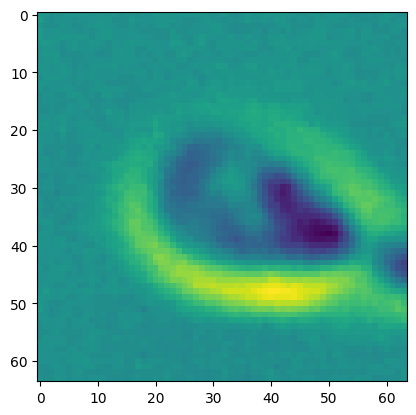

In [20]:
plt.imshow(PILimage(x_train_tensor[0]))

## **Data Normalization**

### **Mean**

In [21]:
mean_train = x_train_tensor.view(1, -1).mean(dim=1)
mean_valid = x_valid_tensor.view(1, -1).mean(dim=1)
mean_test = x_test_tensor.view(1, -1).mean(dim=1)

In [22]:
mean_train, mean_valid, mean_test

(tensor([125.7673]), tensor([126.1020]), tensor([125.9759]))

### **Standard Deviation**

In [23]:
std_train = x_train_tensor.view(1, -1).std(dim=1)
std_valid = x_valid_tensor.view(1, -1).std(dim=1)
std_test = x_test_tensor.view(1, -1).std(dim=1)

In [24]:
std_train, std_valid, std_test

(tensor([13.1974]), tensor([13.4397]), tensor([13.3606]))

### **Normalizarion**

In [25]:
Normalizer = Normalize(128, 8)
x_train_norm = Normalizer(x_train_tensor)

In [26]:
Normalizer = Normalize(mean_valid, std_valid)
x_valid_norm = Normalizer(x_valid_tensor)

In [27]:
Normalizer = Normalize(mean_test, std_test)
x_test_norm = Normalizer(x_test_tensor)

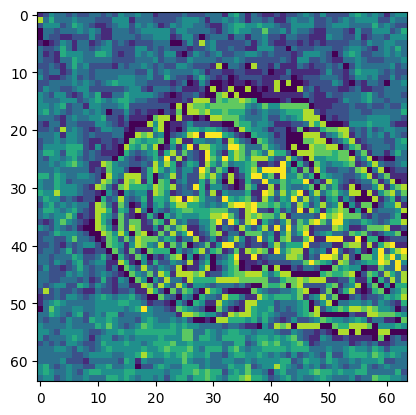

In [28]:
plt.imshow(PILimage(x_train_norm[0]))

## **RGB**

In [29]:
x_train_rgb = torch.stack([img.repeat(3, 1, 1) for img in x_train_tensor])

x_valid_rgb = torch.stack([img.repeat(3, 1, 1) for img in x_valid_tensor])

x_test_rgb = torch.stack([img.repeat(3, 1, 1) for img in x_test_tensor])

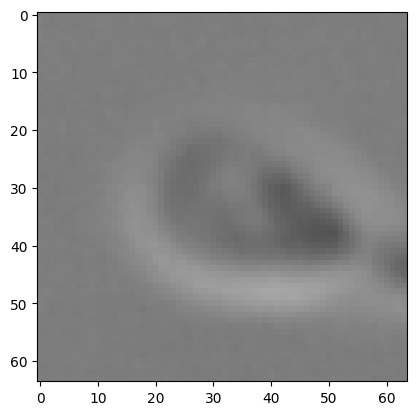

In [30]:
plt.imshow(PILimage(x_train_rgb[0]))

## **Data Augmentation**

In [31]:
transformers = [
    T.functional.vflip,
    T.functional.invert,
    T.functional.hflip,
]

In [32]:
randomAug = T.RandomApply([T.RandomChoice(transformers, p=[0.5, 0.5, 0.5])], p=0.5)

In [33]:
x_def = x_train_rgb[:5]
x_aug = torch.stack([randomAug(x) for x in x_def])

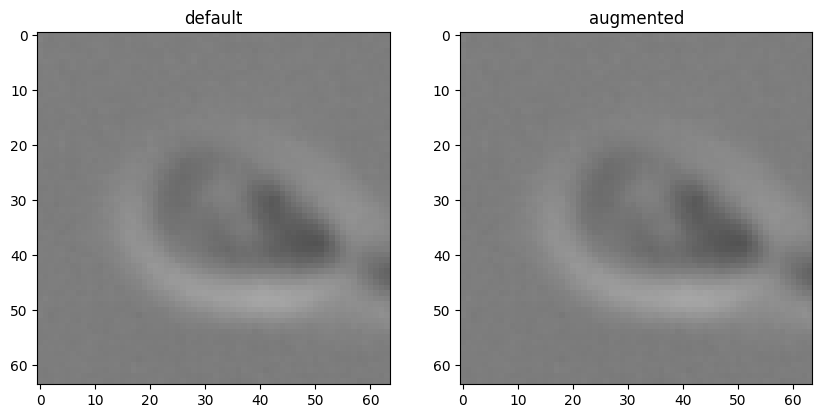

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(10,5))

axs[0, 0].title.set_text('default')
axs[0, 1].title.set_text('augmented')
axs[0, 0].imshow(PILimage(x_def[0]))
axs[0, 1].imshow(PILimage(x_aug[0]))

plt.show()

In [35]:
type(x_def), type(x_aug[0])

(torch.Tensor, torch.Tensor)

### **Equal Distribution**

In [36]:
classes, class_samples = np.unique(y_head_train_tensor, return_counts=True)
classes, class_samples

(array([0., 1.], dtype=float32), array([727, 273]))

In [37]:
false_ids = np.random.choice(np.where(y_head_train_tensor == classes[0])[0], size=class_samples[1])
true_ids = np.where(y_head_train_tensor == classes[1])[0]
ids = np.sort(np.concatenate((false_ids, true_ids), axis=0))

In [38]:
x_train_equal = x_train_tensor[ids]
y_head_train_equal = y_head_train_tensor[ids]
x_train_equal.shape, y_head_train_equal.shape

(torch.Size([546, 1, 64, 64]), torch.Size([546]))

In [39]:
y_head_train_equal

tensor([1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
        1., 1., 1., 0., 0., 0., 0., 1., 

## **Dataset**

In [40]:
class MHSMADataset(Dataset):
  def __init__(self, x, y, transform=None, target_transform=None):
    self.img_labels = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    image = self.imgs[idx]
    label = self.img_labels[idx]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [41]:
class MultiLabelMHSMADataset(Dataset):
  def __init__(self, x, y_acrosome, y_head, y_tail, y_vacuole, transform=None, target_transform=None):

    self.imgs = x

    self.len = len(y_acrosome)

    self.img_labels = {}
    self.img_labels['acrosome'] = y_acrosome
    self.img_labels['head'] = y_head
    self.img_labels['tail'] = y_tail
    self.img_labels['vacuole'] = y_vacuole

    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    image = self.imgs[idx]

    label = {}
    label['acrosome'] = self.img_labels['acrosome'][idx]
    label['head'] = self.img_labels['head'][idx]
    label['tail'] = self.img_labels['tail'][idx]
    label['vacuole'] = self.img_labels['vacuole'][idx]

    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [42]:
MHSMAData = {}

MHSMAData['train'] = MHSMADataset(x=x_train_tensor, y=y_head_train_tensor)

MHSMAData['valid'] = MHSMADataset(x=x_valid_tensor, y=y_head_valid_tensor)

MHSMAData['test'] = MHSMADataset(x=x_test_tensor, y=y_head_test_tensor)

In [43]:
dataset_sizes = {}

dataset_sizes['train'] = len(MHSMAData['train'])
dataset_sizes['valid'] = len(MHSMAData['valid'])
dataset_sizes['test'] = len(MHSMAData['test'])

In [44]:
MHSMADataRGB = {}

MHSMADataRGB['train'] = MHSMADataset(x=x_train_rgb, y=y_head_train_tensor)

MHSMADataRGB['valid'] = MHSMADataset(x=x_valid_rgb, y=y_head_valid_tensor)

MHSMADataRGB['test'] = MHSMADataset(x=x_test_rgb, y=y_head_test_tensor)

In [45]:
MultiLabelMHSMADataset

MultiLabelMHSMADataRGB = {}

MultiLabelMHSMADataRGB['train'] = MultiLabelMHSMADataset(x_train_rgb, y_acrosome_train, y_head_train, y_tail_train, y_vacuole_train)

MultiLabelMHSMADataRGB['valid'] = MultiLabelMHSMADataset(x_valid_rgb, y_acrosome_valid, y_head_valid, y_tail_valid, y_vacuole_valid)

MultiLabelMHSMADataRGB['test'] = MultiLabelMHSMADataset(x_test_rgb, y_acrosome_test, y_head_test, y_tail_test, y_vacuole_test)

## **Data Loader**

### **Default Dataloader**

In [46]:
batch_size=64
dataloaders = {}

dataloaders['train'] = DataLoader(MHSMAData['train'], batch_size=batch_size, shuffle=True)
dataloaders['valid'] = DataLoader(MHSMAData['valid'], batch_size=batch_size, shuffle=True)
dataloaders['test'] = DataLoader(MHSMAData['test'], batch_size=batch_size, shuffle=True)

In [47]:
dataloader_sizes = {}

dataloader_sizes['train'] = len(dataloaders['train'])
dataloader_sizes['valid'] = len(dataloaders['valid'])
dataloader_sizes['test'] = len(dataloaders['test'])

### **RGB Dataloader**

In [48]:
batch_size=64
dataloaders_rgb = {}
dataloaders_rgb['train'] = DataLoader(MHSMADataRGB['train'], batch_size=batch_size, shuffle=True, num_workers=2)
dataloaders_rgb['valid'] = DataLoader(MHSMADataRGB['valid'], batch_size=batch_size, shuffle=True, num_workers=2)
dataloaders_rgb['test'] = DataLoader(MHSMADataRGB['test'], batch_size=batch_size, shuffle=True, num_workers=2)

In [49]:
dataloader_rgb_sizes = {}

dataloader_rgb_sizes['train'] = len(dataloaders_rgb['train'])
dataloader_rgb_sizes['valid'] = len(dataloaders_rgb['valid'])
dataloader_rgb_sizes['test'] = len(dataloaders_rgb['test'])

In [50]:
train_batch_num = len(dataloaders_rgb['train'])

In [51]:
# train_features, train_labels = next(iter(train_dataloader))

### **Meta**

In [52]:
train_metadata = l2l.data.MetaDataset(MHSMADataRGB['train'])

valid_metadata = l2l.data.MetaDataset(MHSMADataRGB['valid'])

test_metadata = l2l.data.MetaDataset(MHSMADataRGB['test'])

In [53]:
transforms = [
    l2l.data.transforms.NWays(train_metadata, n=2), # number of output classes
    l2l.data.transforms.KShots(train_metadata, k=2*5), # number of shots per iteration
    l2l.data.transforms.LoadData(train_metadata),
]
tasksets = {}
tasksets['train'] = l2l.data.Taskset(train_metadata, transforms, num_tasks=1)
tasksets['valid'] = l2l.data.Taskset(train_metadata, transforms, num_tasks=1)
tasksets['test'] = l2l.data.Taskset(train_metadata, transforms, num_tasks=1)

In [54]:
# batch_size=32

# train_metaDataloader_rgb = DataLoader(train_metadata, batch_size=batch_size, shuffle=True, num_workers=2)
# valid_metaDataloader_rgb = DataLoader(valid_metadata, batch_size=batch_size, shuffle=True, num_workers=2)
# test_metaDataloader_rgb = DataLoader(test_metadata, batch_size=batch_size, shuffle=True, num_workers=2)

In [55]:
# metaDataloaders_rgb = {}

# metaDataloaders_rgb['train'] = train_metaDataloader_rgb
# metaDataloaders_rgb['valid'] = valid_metaDataloader_rgb
# metaDataloaders_rgb['test'] = test_metaDataloader_rgb

In [56]:
# metaDataloader_rgb_sizes ={}

# metaDataloader_rgb_sizes['train'] = len(train_dataloader_rgb)
# metaDataloader_rgb_sizes['valid'] = len(valid_dataloader_rgb)
# metaDataloader_rgb_sizes['test'] = len(test_dataloader_rgb)

# **Helper Functions**

### **GPU**

In [63]:
def setGPU(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  device = torch.device('cpu')

  if cuda:
      torch.cuda.manual_seed(seed)
      device = torch.device('cuda')

  return device

device = setGPU()
print(device)

cuda


### **Train**

In [64]:
def train_model(model, criterion, optimizer, scheduler, dataloader, dataloader_size, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 20)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0
      # running_acc = 0.0

      # Iterate over data.
      for inputs, labels in dataloader[phase]:
        inputs = inputs.to(device)
        labels = labels.type(torch.LongTensor).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          # acc = binary_accuracy(outputs.reshape(outputs.shape[0]), labels.reshape(labels.shape[0]), threshold=0.5)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        # running_acc += acc

        # if phase == 'train':
        #   scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

### **Evaluation**

In [88]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

In [65]:
def evaluate_model(model, criterion, dataloader, dataloader_size, dataset_size):
  since = time.time()

  # print('-' * 20)

  # Each epoch has a training and validation phase
  model.eval()   # Set model to evaluate mode

  running_loss = 0.0
  running_corrects = 0
  # running_acc = 0.0

  # Iterate over data.
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  eval_loss = running_loss / dataset_size
  eval_acc = running_corrects.double() / dataset_size

  return eval_loss, eval_acc

  # print(f'test Loss: {eval_loss:.4f} Acc: {eval_acc:.4f}')

# **Models**

### **N-Shot Task Sampler**

In [66]:
class NShotTaskSampler(Sampler):
    def __init__(self,
                 dataset: torch.utils.data.Dataset,
                 episodes_per_epoch: int = None,
                 n: int = None,
                 k: int = None,
                 q: int = None,
                 num_tasks: int = 1):
        """PyTorch Sampler subclass that generates batches of n-shot, k-way,
        q-query tasks.

        Each n-shot task contains a "support set" of `k` sets of `n` samples and
        a "query set" of `k` sets of `q` samples. The support set and the query set
        are all grouped into one Tensor such that the first n * k samples are from
        the support set while the remaining q * k samples are from the query set.

        The support and query sets are sampled such that they are disjoint
        i.e. do not contain overlapping samples.

        # Arguments
            dataset: Instance of torch.utils.data.Dataset from which to draw samples
            episodes_per_epoch: Arbitrary number of batches of n-shot tasks to
                                generate in one epoch
            n_shot: int. Number of samples for each class in the n-shot
                            classification tasks.
            k_way: int. Number of classes in the n-shot classification tasks.
            q_queries: int. Number query samples for each class in the n-shot
                            classification tasks.
            num_tasks: Number of n-shot tasks to group into a single batch
        """
        super(NShotTaskSampler, self).__init__(dataset)
        self.episodes_per_epoch = episodes_per_epoch
        self.dataset = dataset
        if num_tasks < 1:
            raise ValueError('num_tasks must be > 1.')

        self.num_tasks = num_tasks
        # TODO: Raise errors if initialise badly
        self.k = k
        self.n = n
        self.q = q

    def __len__(self):
        return self.episodes_per_epoch

    def __iter__(self):
        for _ in range(self.episodes_per_epoch):
            batch = []

            for task in range(self.num_tasks):
                # Get random classes
                episode_classes = np.unique(self.dataset.img_labels, return_counts=False)


                for k in episode_classes:
                    # Randomly choose support indicies
                    support_ids = np.random.choice(np.where(self.dataset.img_labels == k)[0], size=self.n)
                    for x in support_ids:
                        batch.append(x)

                for k in episode_classes:
                  # Randomly choose query indicies (except selected indicies in support)
                    query=np.setdiff1d(np.where(self.dataset.img_labels == k)[0], support_ids)
                    query = query[np.random.choice(query.shape[0], self.q, replace=False)]
                    for x in query:
                        batch.append(x)

            yield np.stack(batch)


### **Meta Adaption Functions**

#### **Fast Adapt**

In [121]:
def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.type(torch.LongTensor).to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.arange(shots*ways) * 2 # even indicies
    evaluation_indices = np.arange(shots*ways) * 2 + 1 # odd indicies

    # adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    adaptation_data = torch.stack([randomAug(data[i]) for i in adaptation_indices])
    adaptation_labels = labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        adaptation_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(adaptation_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    evaluation_error = loss(predictions, evaluation_labels)
    evaluation_accuracy = accuracy(predictions, evaluation_labels)
    return evaluation_error, evaluation_accuracy

#### **Meta Train**

In [105]:
def meta_train(ways=2,
          shots=10,
          meta_lr=0.001,#0.003
          fast_lr=0.003,#0.5
          meta_batch_size=32,#32
          adaptation_steps=2,
          num_iterations=100,#60000
          cuda=True,
          seed=42):

    best_valid_error = float('inf')
    best_valid_acc = 0

    for iteration in range(num_iterations):
        opt.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0
        learner = None
        for train_batch, val_batch in zip(train_taskloader, dev_taskloader): # epoch_len     #range(meta_batch_size):
            # Compute meta-training loss
            learner = maml.clone()
            evaluation_error, evaluation_accuracy = fast_adapt(train_batch, learner, loss, adaptation_steps, shots, ways, device)

            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            learner = maml.clone()

            evaluation_error, evaluation_accuracy = fast_adapt(val_batch, learner, loss, adaptation_steps, shots, ways, device)

            meta_valid_error += evaluation_error.item()
            meta_valid_accuracy += evaluation_accuracy.item()

        # Compute validation loss and accuracy
        valid_error, valid_acc = evaluate_model(learner, loss, dataloaders_rgb['valid'], dataloader_rgb_sizes['valid'], dataset_sizes['valid'])

        if valid_acc > best_valid_acc:
          best_valid_acc = valid_acc
          best_valid_error = valid_error
          print(f'\n** best val acc: {best_valid_acc:.4f} **')
          torch.save(learner, MAML_path)

        # Print some metrics
        print('\n')
        print('Iteration', iteration + 1)
        print('Meta Train Error', meta_train_error / meta_batch_size)
        print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
        print('Meta Valid Error', meta_valid_error / meta_batch_size)
        print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)
        print(f'Valid Error: {valid_error:.4f}')
        print(f'Valid Accuracy: {valid_acc:.4f}')

        # Average the accumulated gradients and optimize
        for p in maml.parameters():
          if p.requires_grad:
            p.grad.data.mul_(1.0 / meta_batch_size)

        opt.step()

### **MAML**

#### **Task Sampler**

In [99]:
ways=2
shots=10
meta_batch_size=32
epoch_len = meta_batch_size

train_taskloader = DataLoader(MHSMADataRGB['train'], batch_sampler=NShotTaskSampler(MHSMADataRGB['train'], epoch_len, n=2*shots, k=ways, q=0, num_tasks=1), num_workers=2)

dev_taskloader = DataLoader(MHSMADataRGB['valid'], batch_sampler=NShotTaskSampler(MHSMADataRGB['valid'], epoch_len, n=0, k=ways, q=2*shots, num_tasks=1), num_workers=2)

test_taskloader = DataLoader(MHSMADataRGB['test'], batch_sampler=NShotTaskSampler(MHSMADataRGB['test'], epoch_len, n=0, k=ways, q=2*shots, num_tasks=1), num_workers=2)


#### **Base Model**

##### **VGG11**

###### **Configuration**

In [ ]:
#64 shot = 10, adaption = 10

In [ ]:
vgg11 = torchvision.models.vgg11_bn(pretrained=True)
num_ftrs = vgg11.classifier[0].in_features
vgg11.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 2048),
    nn.ReLU(),
    nn.Dropout(0.9),
    nn.Linear(2048, 1024),
    nn.Sigmoid(),
    nn.Dropout(0.9),
    nn.Linear(1024, 2)
)
MAML_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/MAML_head_vgg11_2.pt"
vgg11.classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:09<00:00, 53.4MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.9, inplace=False)
  (3): Linear(in_features=2048, out_features=1024, bias=True)
  (4): Sigmoid()
  (5): Dropout(p=0.9, inplace=False)
  (6): Linear(in_features=1024, out_features=2, bias=True)
)

###### **Train**

In [ ]:
meta_lr=1e-3
fast_lr=1e-3
adaptation_steps=10
num_iterations=50
seed=42

# Create model
model = vgg11
model.to(device)
maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False, allow_nograd=True)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, maml.parameters()), meta_lr)
loss = nn.CrossEntropyLoss()

In [ ]:
meta_train(ways, shots, meta_lr, fast_lr, meta_batch_size, adaptation_steps, num_iterations)



Iteration 1
Meta Train Error 0.813240384683013
Meta Train Accuracy 0.5328125087544322
Meta Valid Error 0.8616312202066183
Meta Valid Accuracy 0.5031250081956387


Iteration 2
Meta Train Error 0.9225683398544788
Meta Train Accuracy 0.5000000121071935
Meta Valid Error 0.9172832202166319
Meta Valid Accuracy 0.4937500115483999


Iteration 3
Meta Train Error 0.8668925389647484
Meta Train Accuracy 0.528125012293458
Meta Valid Error 0.8840543460100889
Meta Valid Accuracy 0.5421875128522515


Iteration 4
Meta Train Error 0.7893159557133913
Meta Train Accuracy 0.5406250152736902
Meta Valid Error 0.8251598887145519
Meta Valid Accuracy 0.5453125070780516


Iteration 5
Meta Train Error 0.751199415884912
Meta Train Accuracy 0.5703125093132257
Meta Valid Error 0.7692701797932386
Meta Valid Accuracy 0.5765625098720193


Iteration 6
Meta Train Error 0.7073700977489352
Meta Train Accuracy 0.6265625134110451
Meta Valid Error 0.8464559074491262
Meta Valid Accuracy 0.5437500141561031


Iteration 7
Meta 

###### **Evaluate**

In [ ]:
model = torch.load(MAML_path)

In [ ]:
evaluate_model(model, loss, dataloaders_rgb['valid'], dataloader_rgb_sizes['valid'], dataset_sizes['valid'])

--------------------
test Loss: 0.9532 Acc: 0.7625


In [ ]:
evaluate_model(model, loss, dataloaders_rgb['test'], dataloader_rgb_sizes['test'], dataset_sizes['test'])

--------------------
test Loss: 0.9329 Acc: 0.7800


In [ ]:
torch.save(model, '/content/drive/MyDrive/AI Projects/MAML models/MAML_head_vgg11.pt')

##### **VGG19**

###### **Configuration**

In [ ]:
vgg19 = torchvision.models.vgg19_bn(pretrained=True)
num_ftrs = vgg19.classifier[-1].in_features
vgg19.classifier[-1] = nn.Linear(num_ftrs, 2)
# vgg19.classifier = nn.Sequential(
#     nn.Linear(num_ftrs, 2048),
#     nn.ReLU(),
#     nn.Dropout(0.9),
#     nn.Linear(2048, 1024),
#     nn.Sigmoid(),
#     nn.Dropout(0.9),
#     nn.Linear(1024, 2)
# )

MAML_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/MAML_head_vgg19.pt"
vgg19.classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [ ]:
for param_name, param in vgg19.features.named_parameters():
  param.requires_grad = False
  # print(param_name, param.requires_grad)

In [ ]:
for param_name, param in vgg19.avgpool.named_parameters():
  param.requires_grad = False

In [ ]:
for param_name, param in vgg19.classifier.named_parameters():
  param.requires_grad = True
  # print(param_name, param.requires_grad)

###### **Train**

In [ ]:
meta_lr=2e-3
fast_lr=2e-3
adaptation_steps=5
num_iterations=50
seed=42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')

if cuda:
  torch.cuda.manual_seed(seed)
  device = torch.device('cuda')

In [ ]:
# Create model
vgg19.to(device)
maml = l2l.algorithms.MAML(vgg19, lr=fast_lr, first_order=False, allow_nograd=True)
# opt = torch.optim.Adam(maml.parameters(), meta_lr)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, maml.parameters()), meta_lr)
loss = nn.CrossEntropyLoss()

In [ ]:
meta_train(ways, shots, meta_lr, fast_lr, meta_batch_size, adaptation_steps, num_iterations)

#### **Temp**

In [122]:
vgg11 = torchvision.models.vgg11_bn(pretrained=True)
num_ftrs = vgg11.classifier[0].in_features
vgg11.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 2048),
    nn.ReLU(),
    nn.Dropout(0.9),
    nn.Linear(2048, 1024),
    nn.Sigmoid(),
    nn.Dropout(0.9),
    nn.Linear(1024, 2)
)
MAML_path = "/content/drive/MyDrive/AI Projects/Meta-learning vision project/MAML_head_vgg11_3.pt"
vgg11.classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Linear(in_features=25088, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.9, inplace=False)
  (3): Linear(in_features=2048, out_features=1024, bias=True)
  (4): Sigmoid()
  (5): Dropout(p=0.9, inplace=False)
  (6): Linear(in_features=1024, out_features=2, bias=True)
)

In [123]:
meta_lr=1e-3
fast_lr=1e-3
adaptation_steps=5
num_iterations=50


# Create model
vgg11.to(device)
maml = l2l.algorithms.MAML(vgg11, lr=fast_lr, first_order=False, allow_nograd=True)
opt = torch.optim.Adam(filter(lambda p: p.requires_grad, maml.parameters()), meta_lr)
loss = nn.CrossEntropyLoss()

In [ ]:
meta_train(ways, shots, meta_lr, fast_lr, meta_batch_size, adaptation_steps, num_iterations)


** best val acc: 0.7333 **


Iteration 1
Meta Train Error 0.8923158179968596
Meta Train Accuracy 0.47968750912696123
Meta Valid Error 0.8599483165889978
Meta Valid Accuracy 0.5062500145286322
Valid Error: 0.6138
Valid Accuracy: 0.7333


Iteration 2
Meta Train Error 0.8440498225390911
Meta Train Accuracy 0.5218750117346644
Meta Valid Error 0.8920969925820827
Meta Valid Accuracy 0.5078125093132257
Valid Error: 0.7544
Valid Accuracy: 0.3250


Iteration 3
Meta Train Error 0.9538863636553288
Meta Train Accuracy 0.4546875096857548
Meta Valid Error 0.9808514006435871
Meta Valid Accuracy 0.4453125046566129
Valid Error: 0.7693
Valid Accuracy: 0.3292


Iteration 4
Meta Train Error 0.8400100413709879
Meta Train Accuracy 0.5234375111758709
Meta Valid Error 0.8358618672937155
Meta Valid Accuracy 0.5171875078231096
Valid Error: 0.7569
Valid Accuracy: 0.3375


Iteration 5
Meta Train Error 0.8247400633990765
Meta Train Accuracy 0.5156250121071935
Meta Valid Error 0.8603099137544632
Meta Valid Accurac

##### **Evaluate**

In [72]:
loss = nn.CrossEntropyLoss()

In [70]:
model = torch.load( '/content/drive/MyDrive/AI Projects/MAML models/MAML_head_vgg11_3.pt')

In [ ]:
evaluate_model(model, loss, dataloaders_rgb['valid'], dataloader_rgb_sizes['valid'], dataset_sizes['valid'])

In [ ]:
evaluate_model(model, loss, dataloaders_rgb['test'], dataloader_rgb_sizes['test'], dataset_sizes['test'])

In [88]:
torch.save(model, '/content/drive/MyDrive/AI Projects/MAML models/MAML_head_vgg11_3.pt')